In [276]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
from fuzzywuzzy import fuzz #conda install -c conda-forge fuzzywuzzy
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator #conda install -c conda-forge wordcloud

sns.set_palette("muted")
tweets = pd.read_csv('data/train.csv')
tweets

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [277]:
tweets_text = tweets.loc[:,['text','target']]
tweets_text['target_boolean'] = tweets_text['target']
tweets_text['target'] = tweets_text['target'].transform(lambda x: 'Real' if x == 1 else 'Falso')
tweets_text

,text,target,target_boolean
0,Our Deeds are the Reason of this #earthquake M...,Real,1
1,Forest fire near La Ronge Sask. Canada,Real,1
2,All residents asked to 'shelter in place' are ...,Real,1
3,"13,000 people receive #wildfires evacuation or...",Real,1
4,Just got sent this photo from Ruby #Alaska as ...,Real,1
...,...,...,...
7608,Two giant cranes holding a bridge collapse int...,Real,1
7609,@aria_ahrary @TheTawniest The out of control w...,Real,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,Real,1
7611,Police investigating after an e-bike collided ...,Real,1


# Cuál es la distribución entre tweets Reales y Falsos? 

Text(0.5, 0, 'Tweet')

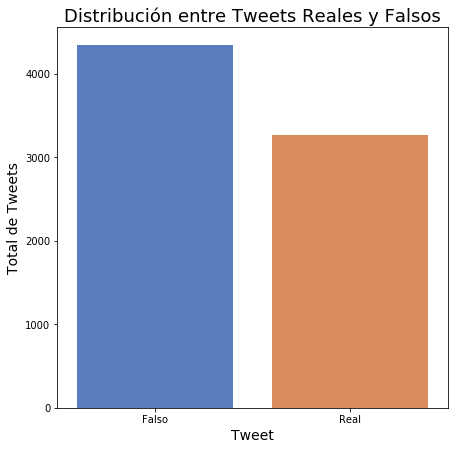

In [278]:
rcParams['figure.figsize'] = 7,7
ax = sns.barplot(data = tweets_text.target.value_counts().reset_index(),x='index',y='target')
ax.set_title("Distribución entre Tweets Reales y Falsos",fontsize= 18)
ax.set_ylabel("Total de Tweets",fontsize= 14)
ax.set_xlabel("Tweet",fontsize= 14)

# Relación cantidad de palabras del tweet y veracidad

Se indica para cada tweet cuantas palabras posee el texto

In [279]:
tweets_text['total_words'] = tweets_text.text.transform(lambda x: len(x.split(" ")))


Text(0, 0.5, 'Frecuencia')

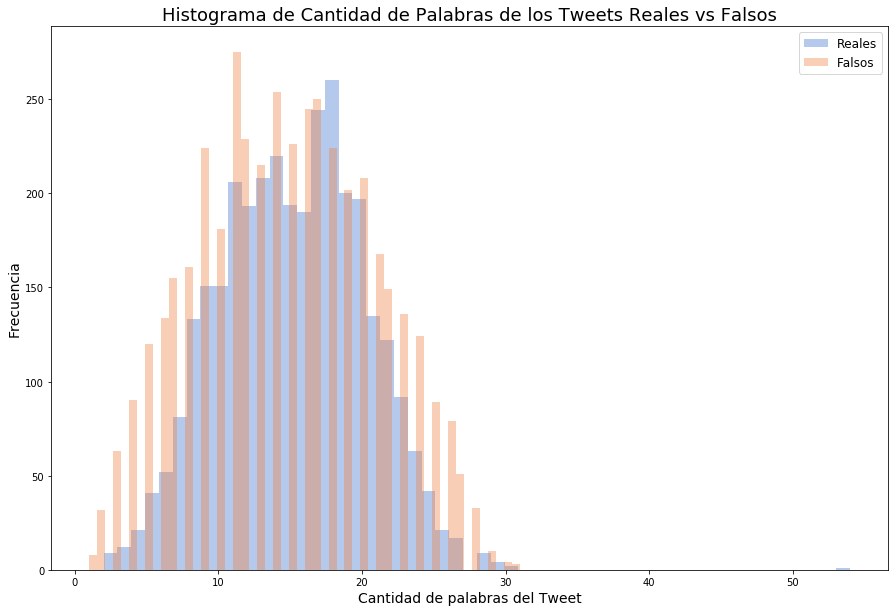

In [280]:
rcParams['figure.figsize'] = 15,10
sns.distplot(tweets_text.loc[tweets_text.target== 'Real','total_words'],  kde=False, label='Reales', bins = 54)
sns.distplot(tweets_text.loc[tweets_text.target== 'Falso','total_words'],  kde=False, label='Falsos',bins = 54)
plt.legend(prop={'size': 12})
plt.title("Histograma de Cantidad de Palabras de los Tweets Reales vs Falsos",fontsize= 18)
plt.xlabel("Cantidad de palabras del Tweet",fontsize= 14)
plt.ylabel('Frecuencia',fontsize= 14)

# Relación entre la cantidad de caracteres y  veracidad del tweet

In [281]:
tweets_text['len_text'] = tweets_text.text.transform(lambda x: len(x))


Text(0, 0.5, 'Frecuencia')

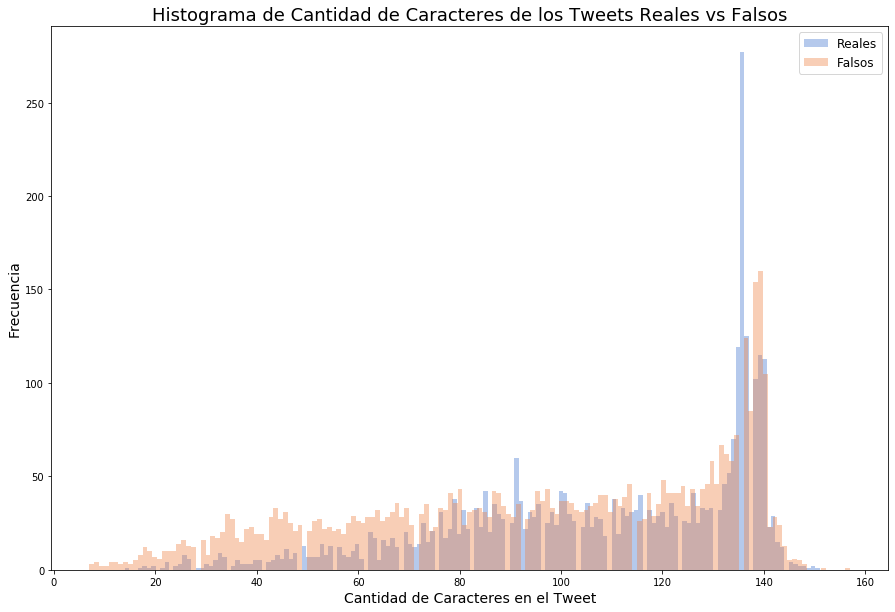

In [282]:
total_bins = tweets_text.len_text.max()
sns.distplot(tweets_text.loc[tweets_text.target== 'Real','len_text'],  kde=False, label='Reales', bins = total_bins)
sns.distplot(tweets_text.loc[tweets_text.target== 'Falso','len_text'],  kde=False, label='Falsos',bins = total_bins)
plt.legend(prop={'size': 12})
plt.title("Histograma de Cantidad de Caracteres de los Tweets Reales vs Falsos",fontsize= 18)
plt.xlabel("Cantidad de Caracteres en el Tweet",fontsize= 14)
plt.ylabel('Frecuencia',fontsize= 14)

# ¿Existe diferencias entre las distribuciones de los tweets según su cantidad de palabras y longitud del texto?

In [283]:
tweets_text['len_text_normal'] = (tweets_text.len_text-tweets_text.len_text.mean()) /np.std(tweets_text.len_text)
tweets_text['total_words_normal'] = (tweets_text.total_words-tweets_text.total_words.mean()) /np.std(tweets_text.total_words)


Text(0.5, 1.0, 'Distribución normalizada (normalización estandar) de\n la cantidad de palabras vs la cantidad de caracteres del texto')

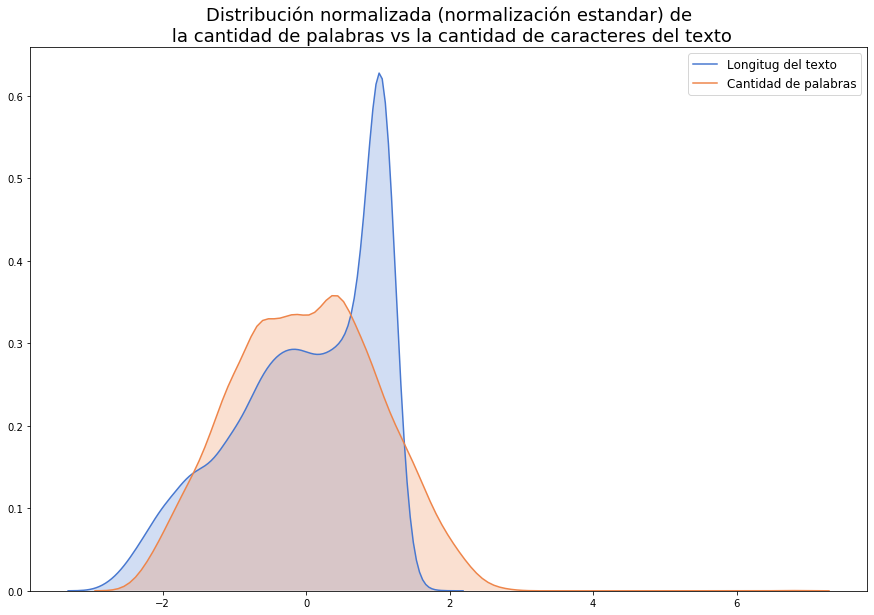

In [284]:
sns.kdeplot(tweets_text.len_text_normal, label='Longitug del texto',shade=True)
sns.kdeplot(tweets_text.total_words_normal, label='Cantidad de palabras',shade=True)
plt.legend(prop={'size': 12})
plt.title("Distribución normalizada (normalización estandar) de\n la cantidad de palabras vs la cantidad de caracteres del texto",fontsize=18)





# Cuál es la correlación entre la cantidad de palabras del tweet y su longitud separados por target?

Text(26.93980577256945, 0.5, 'Total de Palabras')

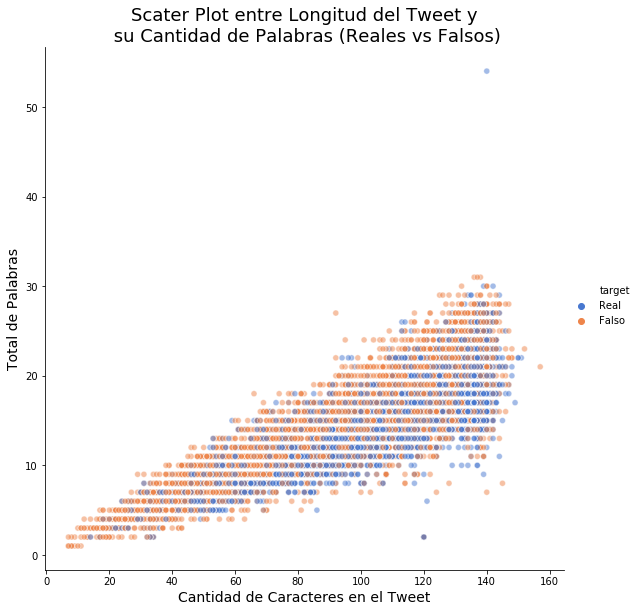

In [285]:
scater = sns.relplot(y="total_words", x="len_text", hue="target", alpha=.5,height=8, data=tweets_text)
plt.title("Scater Plot entre Longitud del Tweet y\n su Cantidad de Palabras (Reales vs Falsos)",fontsize= 18)
plt.xlabel("Cantidad de Caracteres en el Tweet",fontsize= 14)
plt.ylabel('Total de Palabras',fontsize= 14)

# Relación entre la cantidad de caracteres de un tipo específico (mayusculas,numéricos y especiales) y la veracidad del tweet

In [286]:
#Recibe un string y devuelve la cantidad de caracteres en mayusculas que posee
def get_upper_total(s):
    total = 0
    for x in s:
        y = ord(x)
        if y > 90:
            continue
        if y > 64:
            total = total + 1
    return total

#Recibe un string y devuelve la cantidad de caracteres numéricos que posee
def get_total_numbers_chars(s):
    total = 0
    for x in s:
        y = ord(x)
        if y in range(48,58):
            total = total + 1
    return total
#Recibe un string y devuelve la cantidad de caracteres especiales que posee (excluye una lista de caracteres comunes)
def get_special_chars_total(s):
    total = 0
    common_esp_chr = [" ",".","?",",","!"]
    for x in s:
        y = ord(x)
        if y in range(97,123) or y in range(65,91) or y in range(48,58) or x in common_esp_chr:
            continue
        total = total + 1
    return total

Se obtiene para cada tweet la cantidad de caracteres en mayusculas que posee el texto

In [287]:
tweets_text['total_upper_chars'] = tweets_text.text.transform(lambda x: get_upper_total(x))

Se obtiene para cada tweet la cantidad de caracteres numéricos que posee el texto

In [288]:
tweets_text['total_numbers_chars'] = tweets_text.text.transform(lambda x: get_total_numbers_chars(x))

Se obtiene para cada tweet la cantidad de caracteres especiales que posee el texto (sin incluir los mas comunes)

In [289]:
tweets_text['total_special_chars'] = tweets_text.text.transform(lambda x: get_special_chars_total(x))

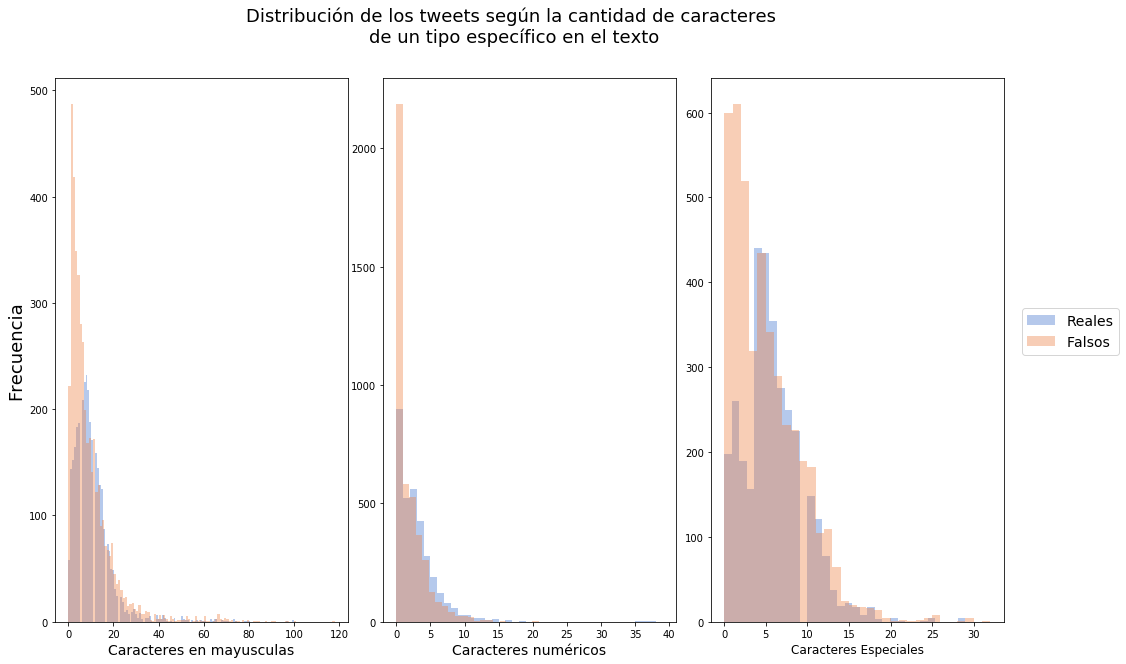

In [290]:

f, ax = plt.subplots(1, 3, figsize=(17,10),gridspec_kw={'wspace': 0.12})

total_bins = tweets_text.total_upper_chars.max()
sns.distplot(tweets_text.loc[tweets_text.target== 'Real','total_upper_chars'],  kde=False, label='Reales', bins = total_bins,ax=ax[0])
sns.distplot(tweets_text.loc[tweets_text.target== 'Falso','total_upper_chars'],  kde=False, label='Falsos',bins = total_bins,ax=ax[0])
ax[0].set_xlabel("Caracteres en mayusculas", fontsize=14)
ax[0].set_ylabel('Frecuencia', fontsize=18)



total_bins = tweets_text.total_numbers_chars.max()
sns.distplot(tweets_text.loc[tweets_text.target== 'Real','total_numbers_chars'],  kde=False, label='Reales', bins = total_bins,ax=ax[1])
sns.distplot(tweets_text.loc[tweets_text.target== 'Falso','total_numbers_chars'],  kde=False, label='Falsos',bins = total_bins,ax=ax[1])
ax[1].set_xlabel("Caracteres numéricos", fontsize=14)



total_bins = tweets_text.total_special_chars.max()
sns.distplot(tweets_text.loc[tweets_text.target== 'Real','total_special_chars'],  kde=False, label='Reales', bins = total_bins,ax=ax[2])
sns.distplot(tweets_text.loc[tweets_text.target== 'Falso','total_special_chars'],  kde=False, label='Falsos',bins = total_bins,ax=ax[2])
ax[2].set_xlabel("Caracteres Especiales", fontsize=12)

f.suptitle('Distribución de los tweets según la cantidad de caracteres \nde un tipo específico en el texto', fontsize=18)
f.legend(["Reales","Falsos"],prop={'size': 14},loc=5)


# ¿Incluyen los tweets elementos especiales como preguntas o enlaces ? como se distribuyen con relación al target

Indicamos para cada tweet si posee o no una pregunta (se asume que la posee si contiene el caracter "?")

In [291]:
tweets_text['contain_question'] = tweets_text.text.transform(lambda x: "?" in x)

Indicamos para cada tweet si posee o no un enlace (se asume que la posee si contiene "http")

In [292]:
tweets_text['contain_link'] = tweets_text.text.transform(lambda x: "http" in x)

Text(0.5, 0.98, 'Bar Plot del target de los tweets que contienen enlaces y preguntas')

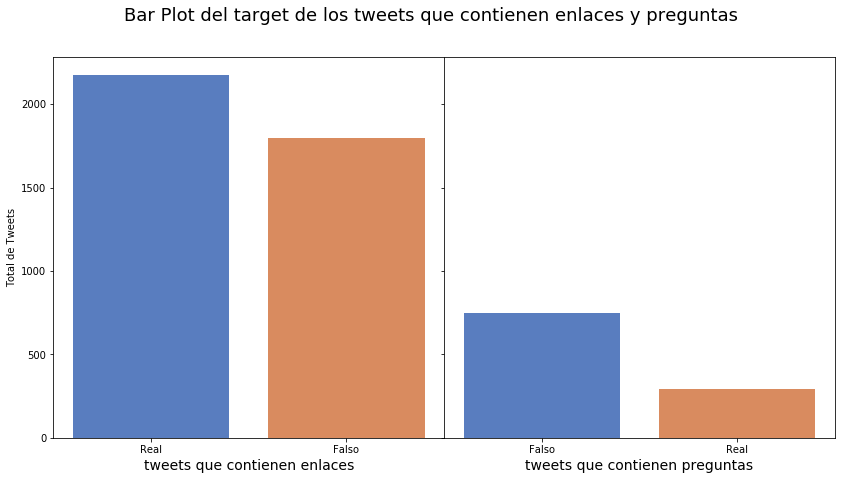

In [293]:
f, ax = plt.subplots(1, 2, figsize=(14,7),gridspec_kw={'wspace': 0})

sns.barplot(data = tweets_text.loc[tweets_text.contain_link == True].target.value_counts().reset_index(),x='index',y='target',ax=ax[0])
ax[0].set_ylabel("Total de Tweets")
ax[0].set_xlabel("tweets que contienen enlaces",fontsize=14)

sns.barplot(data = tweets_text.loc[tweets_text.contain_question == True].target.value_counts().reset_index(),x='index',y='target',ax=ax[1])
ax[1].set_xlabel("tweets que contienen preguntas",fontsize=14)

ax[0].label_outer()
ax[1].label_outer()
ax[1].set_ylim(ax[0].get_ylim())

f.suptitle('Bar Plot del target de los tweets que contienen enlaces y preguntas', fontsize=18)


#  ¿Se puede establecer un conjunto de palabras que dado un tweet que contenga al menos una, indique si es real o falso?


Para esto se hará un analsis de cada palabra en base a su frecuencia y longitud, el cual consistirá en buscar las palabras y su grado de veracidad (sobre aquellos tweets que contienen la palabra: porcentaje que son reales) 

Se crea un DataFrame con todas las palabras y sus frecuencias 

In [294]:
words = []
for x in tweets_text.text.tolist():
    for y in x.split(" "):
        words.append(y.lower())
df_words = pd.Series(words).value_counts().to_frame().reset_index()
df_words.columns = ['word','frecuency']

In [295]:
# Recibe las listas l1=[a1,a2,...,an] y l2=[b1,b2,...,bm] y las extiendea ambas a n x m elementos con la forma:
#  l1=[a1,...,a1,a2,...,a2,...,an,...,an] (m veces para cada elemento)
#  l2=[b1,b2,...,bm,b1,b2,...,bm] (n veces para cada m elementos)
#  Además devuelve una tercera lista con el producto cartesiano de las dos listas anteriores
def separate_cartesian_product_list(lenght_list, frecuency_list):
    first_list = lenght_list.copy()
    second_list = frecuency_list.copy()
    for x in range(len(second_list)-1):
        lenght_list.extend(first_list)
    lenght_list.sort()  
    for x in range(len(first_list)-1):
        frecuency_list.extend(second_list)
    
    third_list = []
    for x in first_list:
        for y in second_list:
            third_list.append((x,y))
    return third_list

In [296]:
#Se crean dos listas, la primera contiene todas las longitudes mínimas y la segunda contiene las frecuencias mínimas
#que se imponen para pertenecer al conjuto de palabras más frecuentes. 
#Se crea un dataframe donde cada registro determina un conjunto de palabras, ya que este contiene las variables antes 
#mencionadas y además una dupla con los mismos valores
word_lenght = list(range(1,10))
word_frecuency = list(range(10,140,5))

len_vs_fre = separate_cartesian_product_list(word_lenght,word_frecuency)
tweets_frec_len = pd.DataFrame({'lenght_min':word_lenght,'frecuency_min':word_frecuency, 'len_and_fre':len_vs_fre}) 


In [297]:
#Recibe un string y una colección de palabras, devuelve True en caso que al menos una de las palabras del string
#este contenida en la colección, Devuelve Falso para el caso contrario. 
def contain_long_words(s,long_words):
    for x in s.lower().split(" "):
        if x in long_words:
            return True
    return False

In [298]:
#Recibe una dupla de elementos: (longitud min,frecuencia min). devuelve el porcentaje de tweets reales de aquellos
#que continen al menos una palabra del conjunto de palabras mas frecuentes determinados por longitud min y frecuencia min
def get_true_percentage(x):
    long_words = df_words.loc[df_words['word'].transform(lambda y: len(y) >=  x[0])].loc[df_words.frecuency >= x[1],'word'].tolist()
    tweets_text['contain_long_word'] = tweets_text['text'].transform(lambda y: contain_long_words(y,long_words))
    tweets_contain_long_words = tweets_text.loc[tweets_text.contain_long_word == True,:]
    total_true =tweets_contain_long_words.loc[tweets_text.target == 'Real','target'].count()
    total_False = tweets_contain_long_words.loc[tweets_text.target == 'Falso','target'].count()

    return total_true*100/(total_true +total_False)

El siguiente dataframe indica los porcentajes de tweets reales de aquellos que por lo menos una de sus palabras se encuentran en las palabras más frecuentes de logintud min y frecuencia min especificados

In [ ]:
tweets_frec_len['true_percentage'] = tweets_frec_len['len_and_fre'].transform(lambda x: get_true_percentage(x)) 
data_for_heatmap =tweets_frec_len.drop(columns=['len_and_fre']).set_index(['frecuency_min','lenght_min']).unstack()
data_for_heatmap.columns = list(range(1,10))
data_for_heatmap


In [ ]:
rcParams['figure.figsize'] = 15,10
heatmap = sns.heatmap(data_for_heatmap,cmap="YlGnBu")
heatmap.set_title("Porcentaje de tweets reales: Tweets que contienen por lo menos \nuna palabra de las palabras mas frecuentes con longitud mayor o igual a n",fontsize= 18)
heatmap.set_xlabel("Longitud mínima de las palabras mas frecuentes",fontsize= 14)
heatmap.set_ylabel("Frecuencia mínima de las palabras mas frecuentes",fontsize= 14)


In [ ]:
def get_true_pertentage_word(x):
    x_list = []
    x_list.append(x)
    tweets_text['contain_long_word'] = tweets_text['text'].transform(lambda y: contain_long_words(y,x_list))
    tweets_contain_long_words = tweets_text.loc[tweets_text.contain_long_word == True,:]
    total_true =tweets_contain_long_words.loc[tweets_text.target == 'Real','target'].count()
    total_False = tweets_contain_long_words.loc[tweets_text.target == 'Falso','target'].count()
    if (total_true +total_False) == False:
        print(x)
        print(tweets_contain_long_words)
    return total_true*100/(total_true +total_False),total_true

In [ ]:
words_set = pd.DataFrame(df_words.loc[df_words['word'].transform(lambda y: len(y) >=  5)].loc[df_words.frecuency >= 30,'word'].tolist())
words_set['percentage_true'] = words_set[0].transform(lambda x: get_true_pertentage_word(x))
words_set['total_tweets_true'] = words_set['percentage_true'].transform(lambda x: x[1]).astype('int')
words_set['percentage_true'] = words_set['percentage_true'].transform(lambda x: x[0]).astype('int')


Se toman las palabras tienen más de un 75% de veracidad y que haya más de 30 de estos (este sería el conjunto de palabras buscados)

In [ ]:
best_words = words_set.loc[words_set.percentage_true > 75].loc[words_set.total_tweets_true >30][0].tolist()


Se indica a cada tweet si contiene o no al menos una palabra de esta "bolsa de palabras"

In [ ]:
tweets_text['contain_long_word'] = tweets_text['text'].transform(lambda y: contain_long_words(y,best_words))

In [ ]:
rcParams['figure.figsize'] = 7,7
ax = sns.barplot(data = tweets_text.loc[tweets_text['contain_long_word'] == True].target.value_counts().reset_index(),x='index',y='target')
ax.set_title("Bar Plot de Tweets que contienen \nal menos una palabra de 'la bolsa de palabras'",fontsize= 18)
ax.set_ylabel("Total de Tweets",fontsize= 14)
ax.set_xlabel("Tweets",fontsize= 14)


# ¿Cuales son los Keywords con mayor frecuencia ?

In [ ]:
tweets_text_key = tweets.loc[:,['text','keyword','target']].dropna()

Agrupación de keyword por similitud

In [ ]:
#Recibe una lista de keywords y regresa un diccionario cuyas claves son los elementos de la lista pasada y los valores
#son las keywords agrupadas que las representa
def get_keyword_dic(key_list):
    key_dic = {}
    unique_list = []
    for x in key_list:
        z = x
        if "%20" in x:
            z = " ".join(x.split("%20"))
        similarity = 0
        value = ""
        for y in unique_list:
            ratio = fuzz.ratio(z,y)
            if ratio > similarity:
                similarity = ratio
                value = y
        if similarity > 75:
            key_dic[x] = value
        else:
            key_dic[x] = z
            unique_list.append(z)
    return key_dic
key_grouped = get_keyword_dic(tweets_text_key.keyword.tolist())

Agrupoamiento manual

In [ ]:
key_grouped['blazing'] = 'ablaze'
key_grouped['bleeding'] = 'blood'
key_grouped['buildings%20on%20fire'] = 'buildings burning'
key_grouped['burning%20buildings'] = 'buildings burning'
key_grouped['burning'] = 'burned'
key_grouped['dead'] = 'death'
key_grouped['demolition'] = 'demolish'
key_grouped['destruction'] = 'destroy'
key_grouped['explosion'] = 'explode'
key_grouped['flood'] = 'flooding'
key_grouped['floods'] = 'flooding'
key_grouped['inundated'] = 'inundation'
key_grouped['panic'] = 'panicking'
key_grouped['rainstorm'] = 'rainstorm'
key_grouped['riot'] = 'rioting'
key_grouped['screaming'] = 'screamed'
key_grouped['snowstorm'] = 'snowstorm'
key_grouped['survivors'] = 'survive'
key_grouped['traumatised'] = 'trauma'
key_grouped['violent%20storm'] = 'storm'
key_grouped['windstorm'] = 'storm'
key_grouped['traumatised'] = 'trauma'

tweets_text_key['keyword_grouped'] = tweets_text_key.keyword.transform(lambda x: key_grouped[x])


 Visualización wordcloud de las keywords categóricas

In [ ]:
def transform_format(val):
    if val == 1:
        return 255
    else:
        return val

keywords_count = tweets_text_key.loc[tweets['target'] == 1].keyword_grouped.value_counts()
keywords_count.index = keywords_count.index.map(str)

mask = np.array(Image.open("./img/twitter_black.png"))
mask_transformed = np.ndarray((mask.shape[0],mask.shape[1]), np.int32)

for i in range(len(mask)):
    mask_transformed[i] = list(map(transform_format, mask[i]))

wordcloud = WordCloud(max_font_size=50, max_words=200, random_state=42, 
                      background_color='white', colormap='gist_heat',
                      mask=mask_transformed)
wordcloud.generate_from_frequencies(keywords_count)

plt.figure(figsize=[15,15])
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Keywords of targeted disaster tweets", fontsize=30, pad=40)
plt.axis("off")
plt.show()

Porcentaje de verdaderos y falsos por cada keyword¶


In [ ]:
keywords_grouped = tweets_text_key.groupby(['keyword_grouped', 'target']).agg({'keyword_grouped':['count']})
keywords_level1 = keywords_grouped.columns.get_level_values(1)
keywords_grouped.columns = keywords_level1
keywords_grouped.reset_index(inplace=True)
keywords_grouped.head(10)

In [ ]:
keywords_total_count = tweets_text_key.groupby(['keyword_grouped']).agg({'keyword_grouped': ['count']})
keywords_total_count.columns = 'total_' + keywords_total_count.columns.get_level_values(1)
keywords_total_count.reset_index(inplace=True)
keywords_total_count.head(10)

In [ ]:
keywords = keywords_grouped.merge(keywords_total_count, left_on='keyword_grouped', right_on='keyword_grouped', how='left')
keywords.loc[:,'percentage_count'] = (keywords.loc[:, 'count'] / keywords.loc[:, 'total_count']) * 100
keywords.head(10)

# Keywords tweets más acertados, tomando como >= 90% targeted y frecuencia mayor a 10 (Verdadero)


In [ ]:
targeted_keywords = keywords.loc[(keywords['percentage_count'] >= 90) & (keywords['total_count'] >= 10) & (keywords['target'] == 1)]
targeted_keywords

In [ ]:
targeted_keywords = targeted_keywords.sort_values(['percentage_count'], ascending=False)
fig, ax = plt.subplots(figsize=(15,10))
ax.tick_params(axis="x", labelsize=15)
ax.tick_params(axis="y", labelsize=15)
g = sns.barplot(x=targeted_keywords['percentage_count'], y=targeted_keywords['keyword_grouped'],
               orient='h')

g.set_title('Keywords with more than 90% targeted', fontsize=15)
g.set_xlabel('Targeted Count Percentage [%]', fontsize=18)
g.set_ylabel('Keyword', fontsize=18)

# Keywords de tweets menos acertados, tomando como >= 90% not targeted y frecuencia mayor a 10 (Falsos)


In [ ]:
not_targeted_keywords = keywords.loc[(keywords['percentage_count'] >= 90) & (keywords['total_count'] >= 10) & (keywords['target'] == 0)]
not_targeted_keywords

In [ ]:
not_targeted_keywords = not_targeted_keywords.sort_values(['percentage_count'], ascending=False)
fig, ax = plt.subplots(figsize=(15,10))
ax.tick_params(axis="x", labelsize=15)
ax.tick_params(axis="y", labelsize=15)
g = sns.barplot(x=not_targeted_keywords['percentage_count'], y=not_targeted_keywords['keyword_grouped'],
               orient='h')

g.set_title('Keywords with more than 90% not targeted', fontsize=15)
g.set_xlabel('Not Targeted Count Percentage [%]', fontsize=18)
g.set_ylabel('Keyword', fontsize=18)

# Cómo varían los resultados anteriores relacionado al texto para el top 15 de desastres con más tweets?

Se agrupan algunas de las keyword y solo nos quedamos con el top15 (por cantidad de tweets)

In [ ]:
key_list_top = tweets_text_key.keyword_grouped.value_counts().nlargest(15).index
tweets_text_key['keyword_top'] = tweets_text_key.keyword_grouped.transform(lambda x: x in key_list_top)
tweets_text_key_top = tweets_text_key.loc[tweets_text_key.keyword_top].copy()
tweets_text_key_top


# Existen preguntas en los tweets del top 15 por tipo de desastre? como se relacionan estas con su veracidad

In [ ]:
tweets_text_key_top['contain_question'] = tweets_text_key_top.text.transform(lambda x: "?" in x)

In [ ]:
rcParams['figure.figsize'] = 12,10

sns.set_color_codes("pastel")
data= tweets_text_key_top.loc[tweets_text_key_top.contain_question == True].groupby(['keyword_grouped']).agg({'text':['count'],'target':['sum']}).reset_index().sort_values(by=('text','count'),ascending=False)
sns.barplot(data = data,y='keyword_grouped',x=('text','count'), color="b",label= 'Total Tweets')

sns.set_color_codes("muted")
ax = sns.barplot(data = data,y='keyword_grouped',x=('target','sum'), color="b",label= 'Total Tweets True')
ax.set_title("Tweets que Poseen preguntas separados por tipo de desastre (Reales vs Total)",fontsize= 18)
ax.set_xlabel("Total de Tweets", fontsize= 14)
ax.set_ylabel("Keyword",fontsize= 14)

ax.legend(ncol=2, loc="lower right", frameon=True)


# Cómo se relaciona los tweets del top 15 por tipo de desastre que poseen  enlaces con su veracidad?

In [ ]:
tweets_text_key_top['contain_link'] = tweets_text_key_top.text.transform(lambda x: "http" in x)

In [ ]:
sns.set_color_codes("pastel")
data= tweets_text_key_top.loc[tweets_text_key_top.contain_link == True].groupby(['keyword_grouped']).agg({'text':['count'],'target':['sum']}).reset_index().sort_values(by=('text','count'),ascending=False)
sns.barplot(data = data,y='keyword_grouped',x=('text','count'), color="b",label= 'Total Tweets')

sns.set_color_codes("muted")
ax = sns.barplot(data = data,y='keyword_grouped',x=('target','sum'), color="b",label= 'Total Tweets True')
ax.set_title("Tweets que Poseen preguntas Enlaces por tipo de desastre (Reales vs Total)",fontsize= 18)
ax.set_xlabel("Total de Tweets",fontsize= 14)
ax.set_ylabel("Keyword",fontsize= 14)
ax.legend(ncol=2, loc="lower right", frameon=True)


# ¿Cómo se relacionan las localidades con el Target?

In [ ]:
#La transformación de las localidades es muy costosa (3 horas), por lo que se ha generado un .csv con esta columna
#agregada, la misma fue generada a través de la librería geopy.geocoders, el cual para una localidad dada devuelve un 
# objeto de tipo Location el cual posee una dirección, latitud y longitud. Esta herramienta permite agrupar por 
#localidades iguales pero escritas de forma distinta (ejemplo: NYC con new york city)

#tomar en cuenta que una parte de los registros no están ya que o no posee localidad o geocoders no pudo hallar su Location

tweets_location = pd.read_csv('./data/tweets_with_clean_location.csv', encoding='utf-8')
tweets_location.loc[:,'keyword'] = tweets_location.loc[:,'keyword'].str.replace("%20", " ")
tweets_location.sample(10)


# Top 5 países con más de 20 tweets y la cantidad de tweets reales relativo de desastre

In [ ]:
count_by_country = tweets_location.groupby(['country']).size().to_frame()
count_by_country.reset_index(inplace=True)
count_by_country.columns = ['country', 'ctry_count']
targeted_tweets_location = tweets_location.loc[tweets_location['target'] == 1].groupby(['country']).size().to_frame()
targeted_tweets_location.reset_index(inplace=True)
targeted_tweets_location.columns = ['country', 'targeted_ctry_count']
count_by_country = count_by_country.merge(targeted_tweets_location, left_on='country', right_on='country')
count_by_country.loc[:,'relative_targeted_ctry_count'] = (count_by_country.loc[:,'targeted_ctry_count'] / count_by_country.loc[:, 'ctry_count'] ) * 100
top_5_ctry_targeted = count_by_country.loc[count_by_country['ctry_count'] > 20].nlargest(5, ['relative_targeted_ctry_count'])



In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
ax.tick_params(axis="x", labelsize=15)
ax.tick_params(axis="y", labelsize=15)
g = sns.barplot(x=top_5_ctry_targeted['relative_targeted_ctry_count'], y=top_5_ctry_targeted['country'],
               orient='h')

g.set_title('Top 5 countries with relative real disaster tweets', fontsize=18)
g.set_xlabel('Relative Tweet Count', fontsize=18)
g.set_ylabel('Country', fontsize=18)

# Top 5 países con más de 20 tweets y la cantidad de tweets falsos relativo de desastre

In [ ]:
not_targeted_tweets_location = tweets_location.loc[tweets_location['target'] == 0].groupby(['country']).size().to_frame()
not_targeted_tweets_location.reset_index(inplace=True)
not_targeted_tweets_location.columns = ['country','not_targeted_ctry_count']
count_by_country = count_by_country.merge(not_targeted_tweets_location, left_on='country', right_on='country')
count_by_country.loc[:,'relative_not_targeted_ctry_count'] = count_by_country.loc[:,'not_targeted_ctry_count'] / count_by_country.loc[:, 'ctry_count']
top_5_ctry_not_targeted = count_by_country.loc[count_by_country['ctry_count'] > 20].nlargest(5, ['relative_not_targeted_ctry_count'])


In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
ax.tick_params(axis="x", labelsize=15)
ax.tick_params(axis="y", labelsize=15)
g = sns.barplot(x=top_5_ctry_not_targeted['relative_not_targeted_ctry_count'], y=top_5_ctry_not_targeted['country'],
               orient='h')

g.set_title('Top 5 countries with relative false disaster tweets', fontsize=18)
g.set_xlabel('Relative Tweet Count', fontsize=18)
g.set_ylabel('Country', fontsize=18)